In [0]:
import numpy as np 
import pandas as pd 
import os
import warnings

In [0]:
import nltk
from nltk.tokenize import word_tokenize# to seperate the words as individual

In [5]:
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM #layers for the sequential model
from keras.callbacks import EarlyStopping #avoid overfitting
from keras.losses import categorical_crossentropy #loss fn
from keras.optimizers import Adam #update rule for the parameters
from keras.models import Sequential


Using TensorFlow backend.


In [0]:
from nltk.stem import WordNetLemmatizer #Lemmatization is the process of grouping together the different 
                                        #inflected forms of a word so they can be analysed as a single item.
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re    #regex
from tqdm import tqdm #tqdm means “progress” in Arabic #tqdm uses smart algorithms to predict the remaining 
#time and to skip unnecessary iteration displays, which allows for a negligible overhead in most cases.

In [0]:
test=pd.read_csv('/content/test.tsv','\t')

In [0]:
train=pd.read_csv('/content/train.tsv','\t')

In [11]:
train.shape


(156060, 4)

In [0]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        #print(sent)
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        #print(review_text)
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)#remove all special text
        #print(review_text)
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        #print(lemma_words)
        #Lemmatization is the process of grouping together the different 
    #inflected forms of a word so they can be analysed as a single item.

        #print(lemma_words)
        reviews.append(lemma_words)

    return(reviews)

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
#cleaned reviews for both train and test set retrieved
#train_sentences = clean_sentences(train)
#test_sentences = clean_sentences(test)#these have been commented as we need to store them in a dataframe for further padding 
#print(len(train_sentences))
#print(len(test_sentences))

In [0]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1] #is 5 as there are 5 classes

In [22]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()#set() method is used to convert any of the iterable to the distinct element and 
                    #sorted sequence of iterable elements
len_max = 0

for sent in tqdm(train_sentences['one']):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
for sent in tqdm(test_sentences):
   unique_words.update(sent)
        
#length of the list of unique_words gives the no of unique words.
print(len(list(unique_words)))#it should be same as the length of the dataframe train_sentences as it is already lemmantized.
print(len_max)

100%|██████████| 156060/156060 [00:00<00:00, 730691.65it/s]

13745
48


In [26]:
for sent in tqdm(test_sentences['one']):
   unique_words.update(sent)

100%|██████████| 66292/66292 [00:00<00:00, 889323.60it/s]


In [27]:
print(len(list(unique_words)))

15884


In [0]:
word_to_int = {word: ii for ii, word in enumerate(unique_words, 1)}#creating a dictioinary to mapp the words to int

In [30]:
len(list(word_to_int))#checking if the len of the dictionary is same as the unique words 

15884

In [86]:
print(word_to_int['study'])


15884


In [18]:
#cleaned reviews for both train and test set retrieved
train_sentences=pd.DataFrame()
test_sentences=pd.DataFrame()
train_sentences['one'] = clean_sentences(train)
test_sentences['one'] = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

  0%|          | 1/156060 [00:01<83:21:39,  1.92s/it]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 66292/66292 [00:32<00:00, 2044.74it/s]

156060
66292


In [19]:
test_sentences.head()


,one
0,"[an, intermittently, pleasing, but, mostly, ro..."
1,"[an, intermittently, pleasing, but, mostly, ro..."
2,[an]
3,"[intermittently, pleasing, but, mostly, routin..."
4,"[intermittently, pleasing, but, mostly, routine]"


In [33]:
 train_sentences['Tokens'] = train_sentences['one'].apply(lambda l: [word_to_int[word] for word in l])
train_sentences['Tokens'].head()#mapping the values

0    [6439, 1661, 11101, 13593, 7962, 5473, 11867, ...
1    [6439, 1661, 11101, 13593, 7962, 5473, 11867, ...
2                                         [6439, 1661]
3                                               [6439]
4                                               [1661]
Name: Tokens, dtype: object

In [32]:
test_sentences['Tokens'] = test_sentences['one'].apply(lambda l: [word_to_int[word] for word in l])
test_sentences['Tokens'].head()

0    [2478, 3379, 6126, 15240, 6514, 12144, 4919]
1    [2478, 3379, 6126, 15240, 6514, 12144, 4919]
2                                          [2478]
3          [3379, 6126, 15240, 6514, 12144, 4919]
4                [3379, 6126, 15240, 6514, 12144]
Name: Tokens, dtype: object

In [58]:
all_tokens = np.array([t for t in train_sentences['Tokens']])
#encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features_train = np.zeros((len(all_tokens), len_max), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features_train[i, :len(row)] = row

#print first 3 values of the feature matrix 
print(features_train[:3])

[[ 6439  1661 11101 13593  7962  5473 11867 13130  3435 13491  1484  1615
   5473  8749 13491  6075  1484  1615  5473   291  8498 11101 13099 12491
   5877 15240   327 11101 13099  8189 15553  6111 11101  6439  7805     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 6439  1661 11101 13593  7962  5473 11867 13130  3435 13491  1484  1615
   5473  8749     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 6439  1661     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [0]:
#The reason for this behavior is that this fixed input length allows for the creation of fixed-shaped tensors and therefore more stable weights.

In [57]:
all_tokens_test = np.array([t for t in test_sentences['Tokens']])
#encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features_test = np.zeros((len(all_tokens_test), len_max), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens_test):
   # print(row)
    if len(row)<=48:
      features_test[i, :len(row)] = row
    else:
      features_test[i, :48] = row[0:48]

#print first 3 values of the feature matrix 
print(features_test[:3])

[[ 2478  3379  6126 15240  6514 12144  4919     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 2478  3379  6126 15240  6514 12144  4919     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 2478     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [0]:
X_train,X_val,y_train,y_val=train_test_split(features_train,y_target,test_size=0.2,stratify=y_target)

In [62]:
X_train.shape

(124848, 48)

In [63]:
X_val.shape

(31212, 48)

In [0]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [130]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words))+1,300,input_length=len_max))#size of embedding layer should be 1 more than the lenth of vocab size
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(32,dropout=0.2, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 300)           4765500   
_________________________________________________________________
lstm_9 (LSTM)                (None, 48, 64)            93440     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               3300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
Total params: 4,875,161
Trainable params: 4,875,161
Non-trainable params: 0
____________________________________________

In [131]:
history=model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=10, batch_size=256, verbose=1, callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 292s 2ms/step - loss: 1.3436 - acc: 0.4970 - val_loss: 1.2813 - val_acc: 0.5100
Epoch 2/10
124848/124848 [==============================] - 285s 2ms/step - loss: 1.2735 - acc: 0.5094 - val_loss: 1.2344 - val_acc: 0.5138
Epoch 3/10
124848/124848 [==============================] - 284s 2ms/step - loss: 1.2302 - acc: 0.5055 - val_loss: 1.2002 - val_acc: 0.5084
Epoch 4/10
124848/124848 [==============================] - 288s 2ms/step - loss: 1.2055 - acc: 0.5077 - val_loss: 1.2034 - val_acc: 0.5290
Epoch 5/10
124848/124848 [==============================] - 285s 2ms/step - loss: 1.1846 - acc: 0.5123 - val_loss: 1.1722 - val_acc: 0.5106
Epoch 6/10
124848/124848 [==============================] - 286s 2ms/step - loss: 1.1727 - acc: 0.5215 - val_loss: 1.1641 - val_acc: 0.5272


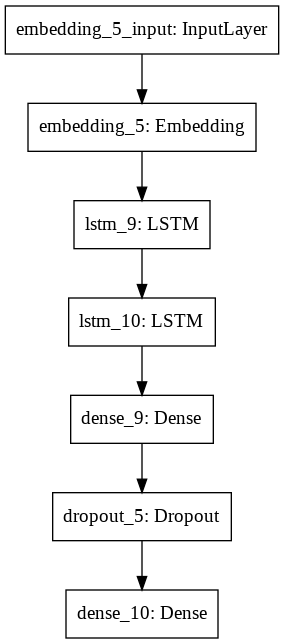

In [133]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')# length of the sequence is 48 i.e. 48 time steps per phrase.

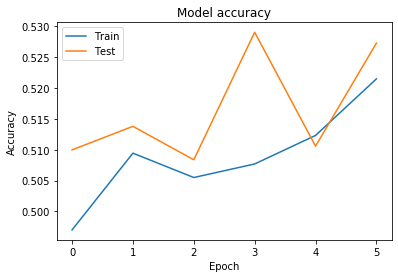

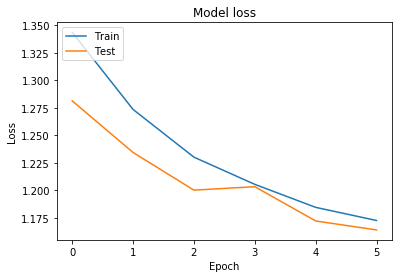

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline
#history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.xlim(0, 2) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig = plt.figure()
fig.savefig('accu.png')
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.xlim(0,2) 
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()#

In [0]:
from IPython.display import Image
Image('/content/accu.png')

In [0]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(features_test)



In [0]:
sub_file = pd.read_csv('/content/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)

In [135]:
 # serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [136]:
model1=Sequential()
model1.add(Embedding(len(list(unique_words))+1,300,input_length=len_max))#size of embedding layer should be 1 more than the lenth of vocab size
model1.add(LSTM(64,dropout=0.2, recurrent_dropout=0.5,return_sequences=True))
model1.add(LSTM(32,dropout=0.2, recurrent_dropout=0.5,return_sequences=False))
model1.add(Dense(100,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 48, 300)           4765500   
_________________________________________________________________
lstm_11 (LSTM)               (None, 48, 64)            93440     
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               3300      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 505       
Total params: 4,875,161
Trainable params: 4,875,161
Non-trainable params: 0
____________________________________________

In [0]:
early_stopping1 = EarlyStopping(min_delta = 0.0001, mode = 'max', monitor='val_acc', patience = 2)
callback1 = [early_stopping1]

In [138]:
history1=model1.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=10, batch_size=251, verbose=1, callbacks=callback1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 286s 2ms/step - loss: 1.2119 - acc: 0.5166 - val_loss: 1.1308 - val_acc: 0.5425
Epoch 2/10
124848/124848 [==============================] - 283s 2ms/step - loss: 1.0541 - acc: 0.5821 - val_loss: 0.9797 - val_acc: 0.6069
Epoch 3/10
124848/124848 [==============================] - 286s 2ms/step - loss: 0.9278 - acc: 0.6308 - val_loss: 0.9179 - val_acc: 0.6238
Epoch 4/10
124848/124848 [==============================] - 285s 2ms/step - loss: 0.8703 - acc: 0.6510 - val_loss: 0.8961 - val_acc: 0.6381
Epoch 5/10
124848/124848 [==============================] - 285s 2ms/step - loss: 0.8358 - acc: 0.6622 - val_loss: 0.8807 - val_acc: 0.6432
Epoch 6/10
124848/124848 [==============================] - 287s 2ms/step - loss: 0.8109 - acc: 0.6718 - val_loss: 0.8699 - val_acc: 0.6473
Epoch 7/10
124848/124848 [==============================] - 283s 2ms/step - loss: 0.8006 - acc: 0.6745 - val_

In [0]:
#make the predictions with trained model and submit the predictions.
y_pred1=model1.predict_classes(features_test)


In [0]:
sub_file1 = pd.read_csv('/content/sampleSubmission.csv',sep=',')
sub_file1.Sentiment=y_pred1
sub_file1.to_csv('Submission1.csv',index=False)

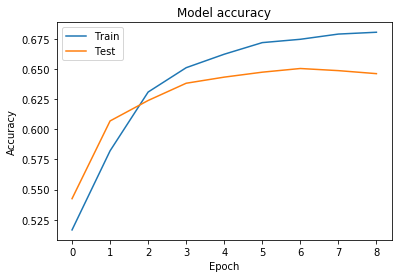

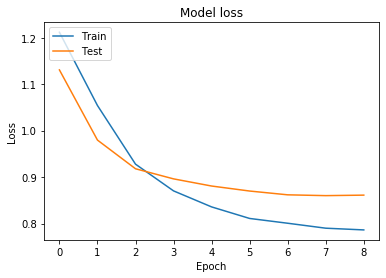

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline
#history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# Plot training & validation accuracy values
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
#plt.xlim(0, 2) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
#plt.xlim(0,2) 
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()#